# Equality constrained analytic centering

<i>minimize</i> $f(x)=-\sum_{i=1}^{n}log(x_i)$ <br>
<i>subject to</i> $Ax=b$ <br>

## Исследование выпуклости задачи

$f(x)$ является суммой функций $-logx_i$
<br><br>
$\frac{d^2}{dx_i^2}(-logx_i) = \frac{1}{x_i^2} > 0$, а значит функция $-logx_i$ - выпуклая. <br>
<br>
Из этого следует что целевая функция $f(x)$ также выпукла так как является суммой выпуклых функций.
Ограничение $Ax=b$ задаёт аффинное множество, которое всегда является выпуклым. Таким образом, задача минимизации является **выпуклой**.

Лагранжиан: <br>
$L(x,λ)=-\sum_{i=1}^{n}(logx_i)+λ^T(Ax-b)$ <br>

Необходимые условия минимума (ККТ): <br>
$\nabla L=-(\frac{1}{x_1},\frac{1}{x_2}, ... ,\frac{1}{x_n})^T+A^Tλ=0 ⇒ A^Tλ=(\frac{1}{x_1},\frac{1}{x_2}, ... ,\frac{1}{x_n})^T$ <br>
$Ax=b$ <br>

В итоге имеем систему: <br>
$\begin{cases}
A^Tλ=diag(x)^{-1}1 \\
Ax=b
\end{cases}$

## Двойственная задача

Определим двойственную функцию как нижнюю границу лагранжиана по переменной $x$:
$g(λ)=\inf\limits_{x > 0} L(x, \lambda)$ <br>
$\nabla L=-(\frac{1}{x_1},\frac{1}{x_2}, ... ,\frac{1}{x_n})^T+A^Tλ=0$ ⇒ рассмотрим условия стационарности ⇒
$\frac{1}{x_i}=(A^Tλ)_i$ ⇒
$x_i=\frac{1}{(A^Tλ)_i}$ <br>

Подставим выраженный $x$ в лагранжиан: <br>
$g(λ)=\sum_{i=1}^{n}(log(A^T\lambda)_i)+\sum_{i=1}^{n}(A^T\lambda_i*\frac{1}{A^T\lambda_i})-\lambda^Tb$ <br>
$g(λ)=\sum_{i=1}^{n}(log(A^T\lambda)_i)+n-\lambda^Tb$

Имеем двойственную задачу: <br>
<i>maximize</i> $\sum_{i=1}^{n}(log(A^T\lambda)_i)+n-\lambda^Tb$ <br>

## Импорты

In [254]:
import numpy as np
import cvxpy as cp
from tqdm import tqdm
import time

## Для каждого значения размерности $n ∈ {10,20,...,100}$ сгенерируйте $N = 100$ тестовых примеров В каждом случае найдите глобальный минимум, $x^* ∈ R^n$, с помощью CVX

In [255]:
# Генерирует задачу гарантированно допустимую и ограниченную снизу
def generate_problem(n):
  x_true = np.random.uniform(low=0.1, high=100, size=n) # Все элементы x > 0
  A = np.random.randn(n, n)
  b = A @ x_true
  return A, b

def solve_problem(A, b):
  n = len(A)
  x = cp.Variable(n)
  objective = cp.Minimize(-cp.sum(cp.log(x)))
  constraints = [A @ x == b]
  prob = cp.Problem(objective, constraints)
  prob.solve()
  if prob.status in ["infeasible", "unbounded"]:
    return None, None
  return x.value, prob.value

dimensions = range(10, 101, 10)
a_generated = {n_val:[] for n_val in dimensions}
b_generated = {n_val:[] for n_val in dimensions}
cvx_opts = {n_val:[] for n_val in dimensions}
cvx_time = {n_val:[] for n_val in dimensions}

N = 100
for n in dimensions:
  for _ in tqdm(range(N), desc=f"Processing N = {n}"):
    A, b = generate_problem(n)
    start_time = time.time()
    x_star, min_value = solve_problem(A, b)
    elapsed_time = time.time() - start_time
    if x_star is None:
      print("The problem is infeasible or unbounded.")
      continue
    cvx_opts[n].append(min_value)
    cvx_time[n].append(elapsed_time)
    b_generated[n].append(b)
    a_generated[n].append(A)

print("\nDone.")

Processing N = 100: 100%|██████████| 100/100 [00:02<00:00, 35.81it/s]


Done.


**<h1>Прямая задача, метод Ньютона</h1>**

In [ ]:
import time

def obj_func(x):
  return -np.sum(np.log(x))

def grad_obj_func(x):
  return -1 / x

def hess_obj_func(x):
  return np.diag(1.0 / (x ** 2))

def solve_problem_newton(x_init, A, b, cvx_opt, max_iters=1000, eps=1e-2, return_history=False):
  x = x_init.copy()
  n = x.shape[0]
  m = A.shape[0]

  A_pinv = np.linalg.pinv(A)
  x = x + A_pinv @ (b - A @ x)
  x = x + np.random.normal(scale=0.05, size=n)
  x = np.maximum(x, 1e-6)

  I = np.eye(n)
  
  prec_history = [abs(obj_func(x) - cvx_opt)]

  for num_iter in range(max_iters):
      inv_x = 1.0 / x # n операций
      grad = -inv_x # n операций
      hess = np.diag(inv_x**2) # 2n операций
      
      KKT_matrix = np.block([ # 2n^2 + n операций
            [hess, A.T],
            [A, np.zeros((m, m))]
      ])

      rhs = np.hstack([-grad, np.zeros(m)]) # n операций

      delta = np.linalg.solve(KKT_matrix, rhs) # (8/3)n^3 операций
      dx = delta[:n]

      #Выбор шага с гарантией положительности
      t = 1.0
      for _ in range(10):
          new_x = x + t * dx # 2n операций
          if np.all(new_x > 0):
              break
          t *= 0.5
      else:
          t = 0.0  # Если не нашли подходящий шаг

      x += t * dx
      
      x = x + A_pinv @ (b - A @ x) # 4n^2 + n операций
      x = np.maximum(x, 1e-6)
      
      precision = abs(obj_func(x) - cvx_opt)
      
      if return_history:
        prec_history.append(precision)

      if precision < eps:
          break
        
  if return_history:
    return x, obj_func(x), abs(obj_func(x) - cvx_opt), num_iter + 1, prec_history

  return x, obj_func(x), abs(obj_func(x) - cvx_opt), num_iter + 1

# Всего (8/3)n^3 + 6n^2 + 9n операций на итерацию

In [257]:
newton_opts = {n_val:[] for n_val in dimensions}
newton_eps = {n_val:[] for n_val in dimensions}
newton_time = {n_val:[] for n_val in dimensions}
newton_iters = {n_val:[] for n_val in dimensions}
data_for_graph = {}
N = 100
for n in dimensions:
  data_for_graph[n] = {}
  print(f"N = {n}")
  for i in tqdm(range(N)):
    data_for_graph[n][i] = {}
    A = a_generated[n][i]
    b = b_generated[n][i]
    cvx_opt = cvx_opts[n][i]
    num_iter = 0
    total_eps = 0
    start_time = time.time()
    for _ in range(100):
      x = np.random.uniform(low=1.0, high=10.0, size=n)
      x_star, min_value, eps, iters = solve_problem_newton(x, A, b, cvx_opt)
      num_iter += iters
      total_eps += eps

      data_for_graph[n][i][_] = {
                                'iter': iters,
                                'eps': eps
                              }
    elapsed_time = time.time() - start_time
    newton_time[n].append(elapsed_time/100)
    newton_iters[n].append(num_iter/100)
    newton_eps[n].append(total_eps/100)
    newton_opts[n].append(min_value)

N = 10


100%|██████████| 100/100 [00:03<00:00, 30.01it/s]


N = 20


100%|██████████| 100/100 [00:05<00:00, 19.45it/s]


N = 30


100%|██████████| 100/100 [00:07<00:00, 12.84it/s]


N = 40


100%|██████████| 100/100 [00:14<00:00,  7.01it/s]


N = 50


100%|██████████| 100/100 [00:27<00:00,  3.62it/s]


N = 60


100%|██████████| 100/100 [00:23<00:00,  4.20it/s]


N = 70


100%|██████████| 100/100 [00:31<00:00,  3.18it/s]


N = 80


100%|██████████| 100/100 [00:33<00:00,  2.96it/s]


N = 90


100%|██████████| 100/100 [00:40<00:00,  2.48it/s]


N = 100


100%|██████████| 100/100 [00:51<00:00,  1.92it/s]


**<h1>Двойственная задача, метод Ньютона</h1>**

In [297]:
def random_feasible_nu(A, seed=None):
    return np.linalg.lstsq(A.T, np.ones(A.shape[1]) * np.random.uniform(low=0.1, high=2.0), rcond=None)[0]

In [ ]:
def dual_grad(nu, A, b):
  inv_ATnu = 1.0 / (A.T @ nu)
  return A @ inv_ATnu - b

def dual_hess(nu, A):
  inv_ATnu_sq = 1.0 / (A.T @ nu)**2
  return -A @ np.diag(inv_ATnu_sq) @ A.T

def dual_obj_func(nu, A, b):
    """Безопасная версия с проверкой допустимости"""
    ATnu = A.T @ nu
    if np.any(ATnu <= 0):
        return -np.inf  # Возвращаем -∞ для недопустимых точек
    return np.sum(np.log(ATnu)) - b.T @ nu + len(ATnu)

def solve_dual_newton(nu_init, A, b, cvx_opt, max_iters=1000, eps=1e-2, return_history=False):
  m = A.shape[0]
  nu = nu_init.copy()
  prev_obj = -np.inf
  I = np.eye(m)
  prec_history = [abs(dual_obj_func(nu, A, b) - cvx_opt)]
  
  for iter in range(max_iters):
    try:
      #Вычисляем ATnu один раз за итерацию
      ATnu = A.T @ nu # 2n^2 - n операций
      if np.any(ATnu <= 0):
          raise ValueError("Недопустимая точка")
      
      #Вычисляем градиент и гессиан
      inv_ATnu = 1.0 / ATnu # n операций
      grad = A @ inv_ATnu - b # 2n^2 операций
      inv_ATnu_sq = inv_ATnu**2 # n операций
      hess = -A @ (inv_ATnu_sq.reshape(-1, 1) * A.T) # 2n^3 - n^2 операций
      
      #Решаем систему с регуляризацией
      KKT = hess + 1e-8 * I # n операций
      dnu = np.linalg.solve(KKT, -grad) # (2/3)n^3 + 2n^2 операций
      
      #Линейный поиск с гарантией ATnu > 0, максимум 40n^2 + 20n - 20 операций
      t = 1.0
      for _ in range(20):
          new_nu = nu + t * dnu
          new_ATnu = A.T @ new_nu
          if np.all(new_ATnu > 0):
              new_obj = np.sum(np.log(new_ATnu)) - b.T @ new_nu + len(new_ATnu)
              if iter == 0 or new_obj > prev_obj + 1e-8:
                break
          t *= 0.5
          
      #Обновление
      nu = new_nu
      prev_obj = new_obj
      
      precision = abs(dual_obj_func(nu, A, b) - cvx_opt)
      
      if return_history:
          prec_history.append(precision)
      
      #Критерий остановки
      if precision < eps:
          break
            
    except Exception as e:
      print(f"Ошибка на итерации {iter}: {str(e)}")
      break

  # Восстановление переменных из прямой задачи
  ATnu = A.T @ nu
  x = 1.0 / ATnu if np.all(ATnu > 0) else np.full(A.shape[1], np.nan)
  
  if precision > eps:
      print('Iterations limit exceeded')
  
  if return_history:
      return nu, dual_obj_func(nu, A, b), precision if np.all(ATnu > 0) else np.inf, iter+1, prec_history
  
  return nu, dual_obj_func(nu, A, b), precision if np.all(ATnu > 0) else np.inf, iter+1

# Всего (8/3)n^3 + 43n^2 + 21n - 20 арифметических операций на итерацию

In [ ]:
newton_opts_dual = {n_val:[] for n_val in dimensions}
newton_eps_dual = {n_val:[] for n_val in dimensions}
newton_time_dual = {n_val:[] for n_val in dimensions}
newton_iters_dual = {n_val:[] for n_val in dimensions}
data_for_graph_dual = {}
N = 100
for n in dimensions:
  data_for_graph_dual[n] = {}
  print(f"N = {n}")
  for i in tqdm(range(N)):
    data_for_graph_dual[n][i] = {}
    A = a_generated[n][i]
    b = b_generated[n][i]
    cvx_opt = cvx_opts[n][i]
    num_iter = 0
    total_eps = 0
    start_time = time.time()
    counted_samples = 100
    for _ in range(100):
      nu_init = random_feasible_nu(A)
      nu_star, min_value, eps, iters = solve_dual_newton(nu_init, A, b, cvx_opt)
      num_iter += iters
      data_for_graph_dual[n][i][_] = {
                                      'iter': iters,
                                      'eps': eps
                                      }
    elapsed_time = time.time() - start_time
    newton_time_dual[n].append(elapsed_time/100)
    newton_iters_dual[n].append(num_iter/100)
    newton_eps_dual[n].append(total_eps/100)
    newton_opts_dual[n].append(min_value)

N = 10


100%|██████████| 100/100 [00:05<00:00, 16.77it/s]


N = 20


100%|██████████| 100/100 [00:18<00:00,  5.52it/s]


N = 30


100%|██████████| 100/100 [00:22<00:00,  4.53it/s]


N = 40


100%|██████████| 100/100 [00:22<00:00,  4.45it/s]


N = 50


100%|██████████| 100/100 [00:33<00:00,  3.00it/s]


N = 60


100%|██████████| 100/100 [00:42<00:00,  2.36it/s]


N = 70


100%|██████████| 100/100 [00:46<00:00,  2.15it/s]


N = 80


100%|██████████| 100/100 [00:54<00:00,  1.84it/s]


N = 90


100%|██████████| 100/100 [00:57<00:00,  1.75it/s]


N = 100


100%|██████████| 100/100 [01:19<00:00,  1.25it/s]


**<h1>Время работы и среднее число итераций</h1>**

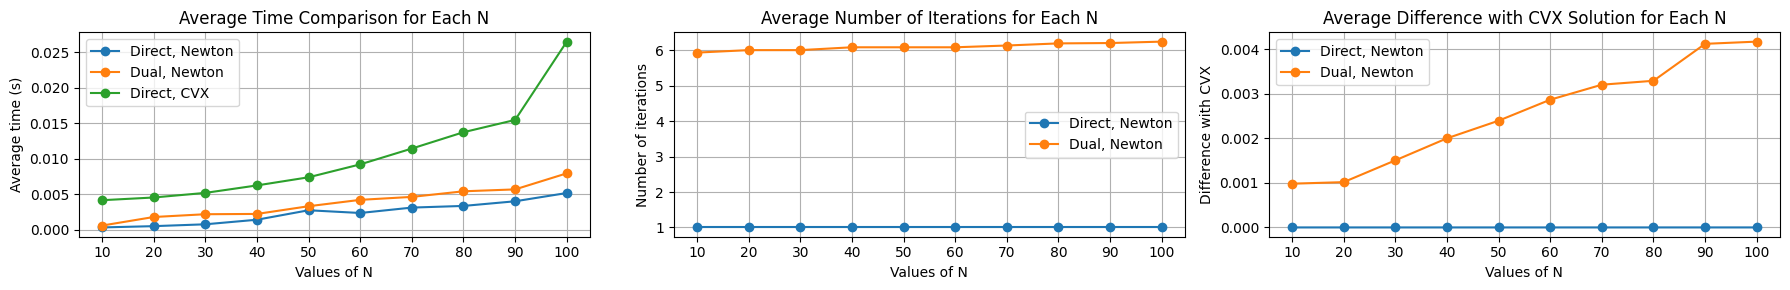

In [ ]:
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

fig, axes = plt.subplots(1, 3, figsize=(18, 3))
axes[0].plot(dimensions, [sum(newton_time[n])/len(newton_time[n]) for n in dimensions], label='Direct, Newton', marker='o', linestyle='-')
axes[0].plot(dimensions, [sum(newton_time_dual[n])/len(newton_time_dual[n]) for n in dimensions], label='Dual, Newton', marker='o', linestyle='-')
axes[0].plot(dimensions, [sum(cvx_time[n])/len(cvx_time[n]) for n in dimensions], label='Direct, CVX', marker='o', linestyle='-')
axes[0].set_xlabel('Values of N')
axes[0].set_ylabel('Average time (s)')
axes[0].set_title('Average Time Comparison for Each N')
axes[0].legend()
axes[0].grid(True)
axes[0].set_xticks(dimensions)

axes[1].plot(dimensions, [sum(newton_iters[n])/len(newton_iters[n]) for n in dimensions], label='Direct, Newton', marker='o', linestyle='-')
axes[1].plot(dimensions, [sum(newton_iters_dual[n])/len(newton_iters_dual[n]) for n in dimensions], label='Dual, Newton', marker='o', linestyle='-')
axes[1].set_xlabel('Values of N')
axes[1].set_ylabel('Number of iterations')
axes[1].set_title('Average Number of Iterations for Each N')
axes[1].legend()
axes[1].grid(True)
axes[1].set_xticks(dimensions)

axes[2].plot(dimensions, [sum(newton_eps[n])/len(newton_eps[n]) for n in dimensions], label='Direct, Newton', marker='o', linestyle='-')
axes[2].plot(dimensions, [sum(newton_eps_dual[n])/len(newton_eps_dual[n]) for n in dimensions], label='Dual, Newton', marker='o', linestyle='-')
axes[2].set_xlabel('Values of N')
axes[2].set_ylabel('Difference with CVX')
axes[2].set_title('Average Difference with CVX Solution for Each N')
axes[2].legend()
axes[2].grid(True)
axes[2].set_xticks(dimensions)

plt.tight_layout()
plt.show()

**<h1>Зависимость точности от числа итераций</h1>**

In [306]:
A, b = generate_problem(n)
cvx_x, cvx_opt = solve_problem(A, b)

n_start_points = 5
primal_precs = []
for _ in range(n_start_points):
      x_init = np.random.uniform(low=1.0, high=1000.0, size=n)
      x_star, min_value, eps, iters, primal_prec = solve_problem_newton(x, A, b, cvx_opt, return_history=True)
      primal_precs.append(primal_prec)

dual_precs = []
for _ in range(n_start_points):      
      nu_init = random_feasible_nu(A)
      nu_star, min_value, eps, iters, dual_prec = solve_dual_newton(nu_init, A, b, cvx_opt, return_history=True)
      dual_precs.append(dual_prec)

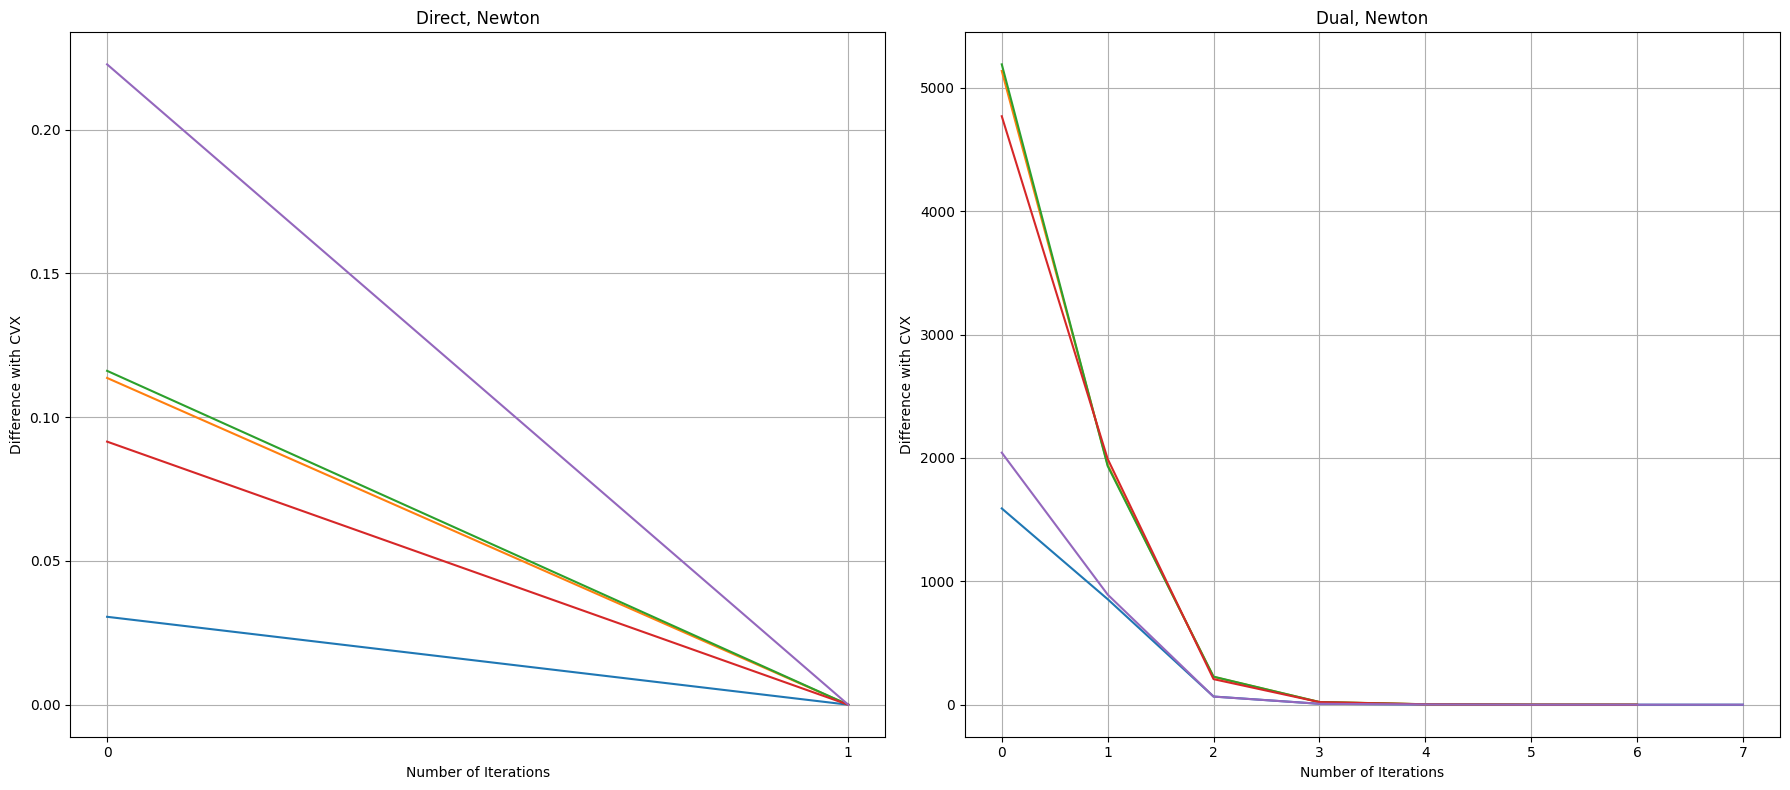

In [311]:
fig, axes = plt.subplots(1, 2, figsize=(18, 8))
for primal in primal_precs:
    axes[0].plot(range(len(primal)), primal)
axes[0].set_xlabel('Number of Iterations')
axes[0].set_ylabel('Difference with CVX')
axes[0].set_title('Direct, Newton')
axes[0].set_xticks([0, 1])
axes[0].grid(True)
    
for dual in dual_precs:
    axes[1].plot(range(len(dual)), dual)
axes[1].set_xlabel('Number of Iterations')
axes[1].set_ylabel('Difference with CVX')
axes[1].set_title('Dual, Newton')
axes[1].grid(True)

plt.tight_layout()
plt.show()

**<h1>Выводы</h1>**
- Метод Ньютона для прямой и двойственной задач работает быстрее, чем CVX солвер.
- Для прямой задачи почти всегда хватает одной итерации, это связано со спецификой задачи. Всякий раз, когда мы проецируем полученную точку на допустимую область Ax=b мы уже получаем решение с необходимой точностью eps=0.01.
- Для двойственного метода в среднем требуется 6 итераций.
- Точность ответов прямого и двойственного методов практически не отличаются, у двойственного метода точность чуть похуже, но в пределах необходимой погрешности.
- Для прямого метода на одной итерации требуется (8/3)n^3 + 6n^2 + 9n арифметических операций, для двойственной задачи (8/3)n^3 + 43n^2 + 21n операций.